# SkillFactory. Data Science. Проект №3.  


### Задача: предсказать рейтинг ресторанов в TripAdvisor.


# Загрузка и инициализация 

## Библиотеки

In [1]:
# Для преобразования и математических операций:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
from datetime import datetime
import re

# Для визуализации:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,7)

# Для разделения датасета:
from sklearn.model_selection import train_test_split

# Для загрузки файлов с пути "../input/".
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# Фиксирую RANDOM_SEED, чтобы мои эксперименты можно было воспроизвести.
RANDOM_SEED = 42

# Фиксирую версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## Датасеты

Загружаются следующие датасеты:
1. **df_train** - дата о ресторанах, на котором тренирую модель. 
2. **df_test** - дата о ресторанах, на которых тестирую модель.
3. **data** - объединенный df_train и df_test, который анализирую, чищу и дополняю информацией.
4. **sample_submission** - дата для вставки предсказанных значений
5. **cities**, **concap.csv**, **worlcities.csv** - датасеты о городах и странах, добавленные с kaggle дополнительно для создания новых признаков.


### main_task.csv, kaggle_task.csv, sample_submission.csv 
 Предоставленные датасеты, содержащие информацию о ресторанах. 

In [3]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
# Подвожу названия столбцов под стандарт PEP-8 
for dataset in [df_train, df_test, sample_submission]:
    dataset.columns = list(map(lambda x: (x.replace(' ', '_')).lower(), dataset.columns))

In [5]:
# Для корректной обработки признаков объединяю трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      50000 non-null  object 
 1   city               50000 non-null  object 
 2   cuisine_style      38410 non-null  object 
 3   ranking            50000 non-null  float64
 4   price_range        32639 non-null  object 
 5   number_of_reviews  46800 non-null  float64
 6   reviews            49998 non-null  object 
 7   url_ta             50000 non-null  object 
 8   id_ta              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


#### Разъяснение признаков
* **city**: Город 
* **cuisine_style**: Кухня
* **ranking**: Ранг ресторана относительно других ресторанов в этом городе
* **price_range**: Цены в ресторане в 3 категориях
* **number_of_reviews**: Количество отзывов
* **reviews**: 2 последних отзыва и даты этих отзывов
* **url_ta**: страница ресторана на 'www.tripadvisor.com' 
* **id_ta**: ID ресторана в TripAdvisor
* **rating**: Рейтинг ресторана

In [7]:
data.sample(5)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating
24987,id_54,Milan,"['Italian', 'Seafood', 'Mediterranean', 'Europ...",55.0,$$$$,1225.0,"[['Best restaurant I have been in Milan', 'Lov...",/Restaurant_Review-g187849-d3701379-Reviews-Al...,d3701379,1,4.5
23536,id_781,Warsaw,NaN,782.0,NaN,4.0,"[[""A truly great cocktail bar in Warsaw's Upp....",/Restaurant_Review-g274856-d12001843-Reviews-B...,d12001843,1,5.0
39138,id_844,Barcelona,"['Gastropub', 'Brew Pub', 'Bar', 'Delicatessen...",845.0,$$ - $$$,116.0,"[['CRAFT BEER', 'Epic chilled eatery'], ['10/0...",/Restaurant_Review-g187497-d9596644-Reviews-Ch...,d9596644,1,4.5
34555,id_589,Bratislava,NaN,590.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274924-d4770161-Reviews-Pa...,d4770161,1,4.0
48101,id_5971,Madrid,NaN,5974.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187514-d5866647-Reviews-CA...,d5866647,1,4.0


### worldcities.csv
Датасет для добавления таких признаков, как страна и популяция.

In [8]:
cities = pd.read_csv('worldcities.csv')
cities = cities[['city','country','population']].copy().set_index('city')
cities.sample(10)

,country,population
city,,
Elva,Estonia,5669.0
Tierra Blanca,Mexico,14515.0
Palmas,Brazil,272726.0
Stannington,United Kingdom,10747.0
Butler,United States,7654.0
Carahue,Chile,11875.0
Caribou,United States,7593.0
Knowle,United Kingdom,10678.0
New Cumberland,United States,7288.0


### countries of the world.csv
Датасет для добавления признаков о стране.

In [9]:
countries = pd.read_csv('countries of the world.csv')
countries = countries[['Country','Coastline (coast/area ratio)','GDP ($ per capita)','Phones (per 1000)','Agriculture', 'Service']].copy()
countries.columns = ['country','coastline','gdp','phones','agriculture','service']
countries = countries.set_index('country')
countries.index = countries.index.str.strip()
countries.sample(10)

,coastline,gdp,phones,agriculture,service
country,,,,,
Macedonia,"0,00",6700.0,"260,0","0,118","0,563"
Virgin Islands,"9,84",17200.0,"652,8","0,01","0,8"
Azerbaijan,"0,00",3400.0,"137,1","0,141","0,402"
Maldives,"214,67",3900.0,"90,0","0,2","0,62"
Palau,"331,66",9000.0,"325,6","0,062","0,818"
Slovakia,"0,00",13300.0,"220,1","0,035","0,672"
Cape Verde,"23,93",1400.0,"169,6","0,121","0,66"
Venezuela,"0,31",4800.0,"140,1","0,04","0,541"
Fiji,"6,18",5800.0,"112,6","0,089","0,776"


### concap.csv
Датасет для добавления признака столицы.

In [10]:
capitals = pd.read_csv('concap.csv')
capitals = capitals[['CountryName','CapitalName']]
capitals.columns  = ['country', 'capital']
capitals = capitals.set_index('country')
capitals.index = capitals.index.str.strip()
capitals

,capital
country,
Somaliland,Hargeisa
South Georgia and South Sandwich Islands,King Edward Point
French Southern and Antarctic Lands,Port-aux-Français
Palestine,Jerusalem
Aland Islands,Mariehamn
...,...
Northern Cyprus,North Nicosia
Hong Kong,NaN
Heard Island and McDonald Islands,NaN


# Предобработка данных и РАД

<!-- ![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png) -->

## Кастомные функции 

In [11]:
# Найти самый часто встречающийся вид кухни по странам или городам. 
def common_cuisine(data, name, by_country = True):
    x = 'country' if by_country else 'city'
    
    stats = data[data[x] == name]['cuisine_style'].value_counts()
    cuisine1 = stats.index[0]
    perc = round(100 * stats.iloc[0]/(stats.iloc[0] + stats.iloc[1] + stats.iloc[2]))
    
    cuisine2 = stats.index[1]
    perc2 = round(100 * stats.iloc[1]/(stats.iloc[0] + stats.iloc[1] + stats.iloc[2]))
    
    cuisine = stats.index[0] + ', ' + stats.index[1]
    
    print(name)
    print('\t '  + ' ' + str(perc) + '%\t' + cuisine1)
    print('\t '  + ' ' + str(perc2) + '%\t' + cuisine2)
    pop_c1.append(cuisine1)
    prc_c1.append(perc)
    pop_c2.append(cuisine2)
    prc_c2.append(perc2)
    
    return cuisine 

In [12]:
# Певести входящие строки в формат даты.
def to_date(*args):
    res = list(map(lambda i: pd.to_datetime(i).date(), args)) 
    if len(res) == 0: 
        return None 
    else:
        return res

In [13]:
# Вычислить разницу в количестве днях между двумя входящими  датами. 
def calculate_diff(*args):
    try:
        res = args[0] - args[1]
        return  abs(res.days)
    except:
        return 0

## Обработка неизвестных значений NaN и создание новых признаков
### Перед обработкой NAN  выношу информацию о наличии пропусков как отдельный признак.  

In [14]:
# Найти столбцы с неизвестными значениями
cols_with_nans = (data.isnull().any()[lambda c: c]).index
cols_with_nans

Index(['cuisine_style', 'price_range', 'number_of_reviews', 'reviews'], dtype='object')

In [15]:
# Создать новый бинарный признак для каждого столбца с неизвестными значениями о наличии пропусков.
for col in cols_with_nans:
    new_col_name = col+'_isNAN'
    data[new_col_name] = pd.isna(data[col]).astype('uint8')

### Разбор столбцов с NaN по отдельности: замена NaN значений и создание взаимосвязанных новых признаков. 
Неизвестные значения имеются в стобцах **cuisine_style**, **price_range**, **number_of_reviews** и **reviews**. Рассматриваю каждый из них по отдельности. Также, дополнительно создаю новые признаки такие, как **country**, **population**, **cuisine_count**. 

#### Признак cuisine_style и новые признаки country и population

**23% (11590) неизвестных значений** 

1. В данном столбце каждая ячейка - строка, хоть и кажется, что в ней находится лист со строками. Преобразую формат ячеек из строки в настоящий лист со строками. 

2. Визуализирую популярность всех представленных в датасете кухонь. Самые популярные кухни по всему датасету ***Vegetarian Friendly*** (11.7%) и ***European*** (10.5%). 

In [16]:
# Посчитать процентное соотношение неизвестных значений. 
stats = data['cuisine_style'].isnull().value_counts()
print(stats)
print(100 * stats[1]/(stats[0]+ stats[1]))

False    38410
True     11590
Name: cuisine_style, dtype: int64
23.18


In [17]:
df = pd.DataFrame(data['cuisine_style'])
df

,cuisine_style
0,"['Bar', 'Pub']"
1,"['European', 'Scandinavian', 'Gluten Free Opti..."
2,['Vegetarian Friendly']
3,"['Italian', 'Mediterranean', 'European', 'Vege..."
4,"['Italian', 'Mediterranean', 'European', 'Seaf..."
...,...
49995,"['Italian', 'Vegetarian Friendly', 'Vegan Opti..."
49996,"['French', 'American', 'Bar', 'European', 'Veg..."
49997,"['Japanese', 'Sushi']"
49998,"['Polish', 'European', 'Eastern European', 'Ce..."


In [18]:
# Привести формат ячейки из формата строки в формат листа, состоящего из строк.
df['cuisine_style'] = df['cuisine_style'].str.strip('[]')
df['cuisine_style'] = df['cuisine_style'].str.replace('\'','')
data['cuisine_style'] = df['cuisine_style'].str.split(', ')
data['cuisine_style'].iloc[0] 

['Bar', 'Pub']

In [19]:
# Найти самый часто встречающийся вид кухни. 
all_cuisine = ''

for x in list(df['cuisine_style'].dropna()):
    all_cuisine = all_cuisine + x + ', '

all_cuisine = all_cuisine.split(', ')
all_cuisine = pd.DataFrame.from_dict(Counter(all_cuisine), orient='index').reset_index()
all_cuisine.columns = ['name', 'count']
all_cuisine.drop(all_cuisine[all_cuisine.name == ''].index, inplace = True)

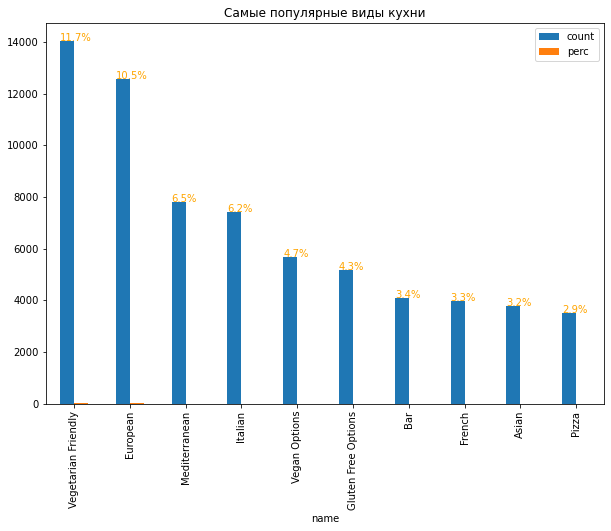

In [20]:
all_cuisine['perc'] = round(all_cuisine['count'] * 100/all_cuisine['count'].sum(),1)
stats = all_cuisine.sort_values(['count'], ascending = False).head(10)

plot = stats.set_index('name').plot.bar(title='Самые популярные виды кухни')

for p, perc in zip(plot.patches,list(stats['perc'])):
    plot.annotate(str(perc)+'%', (p.get_x() , p.get_height()), color='orange')

Прежде чем заполнить неизвестные значения, использую другой датасет, чтобы добавить новый признак **country**. Затем, сгруппировав по признаку **city** или **country**, заполняю неизвестные значение в **cuisine_style**.

In [21]:
# Создать новый признак country в датасете. 
data['country'] = pd.Series(np.array([None]*data.shape[0]))

In [22]:
# Заполнить значение country в главном датасете с помощью датасета о городах. 
for name in data.city.unique():
    if name in cities.index:
        try:
            data.loc[(data.city == name), 'country'] = cities.loc[name].country
        except:
            data.loc[(data.city  == name), 'country'] = cities.loc[name].country.values[0]

In [23]:
# Проверить заполнен country полностью. 
data[data.country.isnull()]

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_style_isNAN,price_range_isNAN,number_of_reviews_isNAN,reviews_isNAN,country
66,id_66,Oporto,NaN,878.0,NaN,7.0,"[[], []]",/Restaurant_Review-g189180-d11667248-Reviews-C...,d11667248,0,0.0,1,1,0,0,None
84,id_84,Krakow,"[Polish, Eastern European, European, Central E...",251.0,$$ - $$$,95.0,"[['The right choice', 'Excellent Polish cuisin...",/Restaurant_Review-g274772-d3331669-Reviews-Go...,d3331669,0,0.0,0,0,0,0,None
124,id_124,Krakow,NaN,936.0,NaN,6.0,"[[], []]",/Restaurant_Review-g274772-d10455057-Reviews-R...,d10455057,0,0.0,1,1,0,0,None
128,id_128,Zurich,NaN,1592.0,NaN,14.0,"[['Cordon Bleu'], ['10/02/2014']]",/Restaurant_Review-g188113-d4961508-Reviews-Re...,d4961508,0,0.0,1,1,0,0,None
144,id_144,Zurich,"[Swiss, European, Central European]",1101.0,$$ - $$$,99.0,"[['Nice atmosphere', 'Good views, but medium f...",/Restaurant_Review-g188113-d2013573-Reviews-Al...,d2013573,0,0.0,0,0,0,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49825,id_433,Zurich,"[Mediterranean, Swiss, European, Vegetarian Fr...",436.0,$$ - $$$,33.0,"[['Hammer!', 'Favourite!'], ['11/15/2017', '10...",/Restaurant_Review-g188113-d10124292-Reviews-S...,d10124292,1,4.5,0,0,0,0,None
49852,id_360,Zurich,"[Chinese, Fast Food, Asian, Vegetarian Friendly]",362.0,$,41.0,"[['Superb Take away place', 'Super good'], ['0...",/Restaurant_Review-g227102-d6675094-Reviews-Ch...,d6675094,1,4.5,0,0,0,0,None
49873,id_430,Oporto,"[European, Portuguese]",431.0,$,65.0,"[['yummy and huge francesinha', 'The best fran...",/Restaurant_Review-g189180-d10146257-Reviews-A...,d10146257,1,4.0,0,0,0,0,None
49895,id_871,Oporto,"[Bar, European, Pub, Portuguese]",872.0,$,141.0,"[['Football on TV', 'Nice place for a glass of...",/Restaurant_Review-g189180-d7315906-Reviews-Cr...,d7315906,1,3.5,0,0,0,0,None


In [24]:
# Заполнить вручную отстутствующие значения для новых признаков.
data.loc[(data.city == 'Oporto'), 'country'] = 'Portugal'
data.loc[(data.city == 'Zurich'), 'country'] = 'Switzerland'
data.loc[(data.city == 'Krakow'), 'country'] = 'Poland'

Чтобы найти самую часто встречающуюся кухню мне нужно использовать ***explode***. Для этого создаю копию датасета tst, чтобы не повлияло на оригинал. 

In [25]:
tst = data.explode('cuisine_style')
tst.sample(5)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_style_isNAN,price_range_isNAN,number_of_reviews_isNAN,reviews_isNAN,country
11675,id_424,Warsaw,European,425.0,$$ - $$$,44.0,"[['Surprising!', 'Not worth taking a trip, ok ...",/Restaurant_Review-g274856-d4914891-Reviews-Ku...,d4914891,1,4.0,0,0,0,0,Poland
36508,id_1531,Hamburg,Indian,1533.0,NaN,2.0,"[['Quality Food'], ['11/22/2013']]",/Restaurant_Review-g187331-d5511881-Reviews-Si...,d5511881,1,4.5,0,1,0,0,Germany
40167,id_924,Paris,Pizza,925.0,$$ - $$$,446.0,"[['Nice find !', ""Good Italian food in one of ...",/Restaurant_Review-g187147-d3395351-Reviews-Ca...,d3395351,1,4.0,0,0,0,0,France
45863,id_1141,Lisbon,Pizza,1142.0,$$ - $$$,12.0,"[['Delicious'], ['11/23/2017']]",/Restaurant_Review-g189158-d12975498-Reviews-P...,d12975498,1,4.5,0,0,0,0,Portugal
45994,id_2614,London,Pizza,2619.0,$$ - $$$,240.0,"[['Good quality Italian food best service!', '...",/Restaurant_Review-g186338-d680441-Reviews-Bel...,d680441,1,4.0,0,0,0,0,United Kingdom


In [26]:
c = []
pop_c1 = []
pop_c2 = []
prc_c1 = []
prc_c2 = []

# Найти популярные кухни по городам.
for city in data['city'].unique():
    c.append(city)
    common_cuisine(tst, city,by_country = False)

Paris
	  46%	French
	  29%	European
Helsinki
	  41%	European
	  38%	Vegetarian Friendly
Edinburgh
	  41%	Vegetarian Friendly
	  30%	British
London
	  47%	Vegetarian Friendly
	  28%	British
Bratislava
	  50%	European
	  29%	Central European
Lisbon
	  41%	European
	  40%	Portuguese
Budapest
	  43%	European
	  34%	Hungarian
Stockholm
	  41%	European
	  34%	Vegetarian Friendly
Rome
	  44%	Italian
	  30%	Vegetarian Friendly
Milan
	  49%	Italian
	  27%	Vegetarian Friendly
Munich
	  47%	Vegetarian Friendly
	  32%	European
Hamburg
	  44%	Vegetarian Friendly
	  32%	European
Prague
	  45%	European
	  36%	Czech
Vienna
	  40%	European
	  31%	Vegetarian Friendly
Dublin
	  36%	Vegetarian Friendly
	  34%	European
Barcelona
	  38%	Spanish
	  37%	Mediterranean
Brussels
	  46%	European
	  28%	Belgian
Madrid
	  49%	Spanish
	  31%	Mediterranean
Oslo
	  40%	European
	  34%	Vegetarian Friendly
Amsterdam
	  40%	European
	  38%	Vegetarian Friendly
Berlin
	  46%	Vegetarian Friendly
	  32%	European
Lyon
	  62%	

In [27]:
data[data.cuisine_style_isNAN == 1].head()

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_style_isNAN,price_range_isNAN,number_of_reviews_isNAN,reviews_isNAN,country
7,id_7,Budapest,NaN,2330.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274887-d8286886-Reviews-Be...,d8286886,0,0.0,1,1,1,0,Hungary
10,id_10,Rome,NaN,1209.0,NaN,306.0,"[['Very pretentious, but drinks are top notch'...",/Restaurant_Review-g187791-d7818546-Reviews-Je...,d7818546,0,0.0,1,1,0,0,Italy
13,id_13,Hamburg,NaN,1000.0,NaN,30.0,"[['Surprisingly good pizza', 'Yummy'], ['09/28...",/Restaurant_Review-g187331-d1344523-Reviews-Il...,d1344523,0,0.0,1,1,0,0,Germany
18,id_18,Vienna,NaN,3360.0,NaN,2.0,"[[], []]",/Restaurant_Review-g190454-d8435085-Reviews-An...,d8435085,0,0.0,1,1,0,0,Austria
20,id_20,Barcelona,NaN,6085.0,NaN,8.0,"[[], []]",/Restaurant_Review-g187497-d8334752-Reviews-Re...,d8334752,0,0.0,1,1,0,0,Spain


Заполняю неизвестные значения самой популярной кухней в стране. 

In [28]:
# Заменить NaN значения по признаку страны.
for name in data.country.unique():
    data.loc[(data.country == name) & (data.cuisine_style_isNAN ==1),'cuisine_style'] = common_cuisine(tst, name,by_country = True)

France
	  48%	French
	  28%	European
Finland
	  41%	European
	  38%	Vegetarian Friendly
United Kingdom
	  47%	Vegetarian Friendly
	  28%	British
Slovakia
	  50%	European
	  29%	Central European
Portugal
	  41%	European
	  40%	Portuguese
Hungary
	  43%	European
	  34%	Hungarian
Sweden
	  41%	European
	  34%	Vegetarian Friendly
Italy
	  46%	Italian
	  29%	Vegetarian Friendly
Germany
	  46%	Vegetarian Friendly
	  32%	European
Czechia
	  45%	European
	  36%	Czech
Austria
	  40%	European
	  31%	Vegetarian Friendly
Ireland
	  36%	Vegetarian Friendly
	  34%	European
Spain
	  43%	Spanish
	  34%	Mediterranean
Belgium
	  46%	European
	  28%	Belgian
Norway
	  40%	European
	  34%	Vegetarian Friendly
Netherlands
	  40%	European
	  38%	Vegetarian Friendly
Greece
	  46%	Greek
	  34%	Mediterranean
Poland
	  42%	European
	  30%	Polish
Denmark
	  43%	European
	  29%	Vegetarian Friendly
Luxembourg
	  44%	European
	  34%	Vegetarian Friendly
Switzerland
	  43%	European
	  38%	Vegetarian Friendly
Slovenia
	

In [29]:
data.cuisine_style = data.cuisine_style.apply(lambda x: x.split(', ') if type(x) == str else x)

In [30]:
data.cuisine_style.isnull().value_counts()

False    50000
Name: cuisine_style, dtype: int64

#### Новый признак cuisine_count
Создаю новый признак - количество видов кухонь предлагаемых в ресторане. Если значение **cuisine_style** неизвестно, то по дефолту **cuisine_count** равен 1. 

In [31]:
data['cuisine_count'] = df['cuisine_style'].str.split(', ').apply(lambda x: 1 if str(x) == 'nan' else len(x))
data[['cuisine_style','cuisine_count']].head(10)

,cuisine_style,cuisine_count
0,"[Bar, Pub]",2
1,"[European, Scandinavian, Gluten Free Options, ...",5
2,[Vegetarian Friendly],1
3,"[Italian, Mediterranean, European, Vegetarian ...",5
4,"[Italian, Mediterranean, European, Seafood, Ve...",6
5,"[French, Cafe, Fast Food]",3
6,"[European, Portuguese]",2
7,"[European, Hungarian]",1
8,"[European, Scandinavian]",2
9,[Italian],1


#### Признак price_range 

**34.7% (17361) неизвестных значений.** 
 
Так как 70.6% ресторанов в ценовом диапазоне от  10-999 долларов, то все неизвестные значения ресторанов будут заменены на этот ценовой диапазон. 

In [32]:
stats = data.price_range.isna().value_counts()
stats[1]*100/(stats[0]+stats[1])

34.722

In [33]:
common_price = data.price_range.value_counts().index[0]

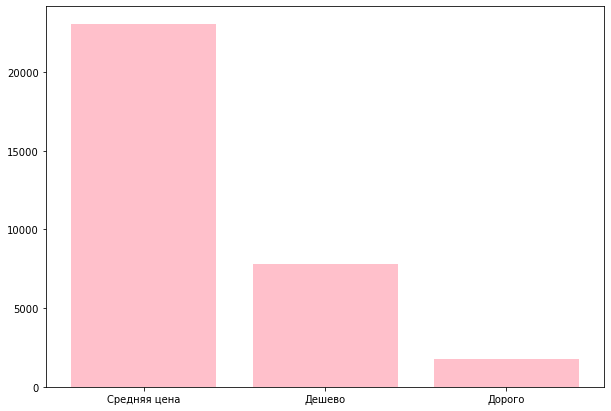

In [34]:
y = data.price_range.value_counts().values
graph = plt.bar(['Средняя цена', 'Дешево', 'Дорого'], y, color = 'pink')

In [35]:
data.price_range.fillna(common_price, inplace = True)

#### Признак reviews
**2 незивестных значения.**

Так как об этих двух ресторанах имеется мало информации, а именно есть 3-4 неизвестных значения, удаляю эти рестораны из датасета полностью.

In [36]:
display(data[data['reviews_isNAN']==1])
print(data.reviews.iloc[1])
print(type(data.reviews.iloc[1]))

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_style_isNAN,price_range_isNAN,number_of_reviews_isNAN,reviews_isNAN,country,cuisine_count
8168,id_8168,Lisbon,"[European, Portuguese]",3389.0,$$ - $$$,2.0,NaN,/Restaurant_Review-g189158-d12683988-Reviews-O...,d12683988,0,0.0,1,1,0,1,Portugal,1
9608,id_9608,Vienna,"[European, Vegetarian Friendly]",1779.0,$$ - $$$,NaN,NaN,/Restaurant_Review-g190454-d12605368-Reviews-R...,d12605368,0,0.0,1,1,1,1,Austria,1


[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]
<class 'str'>


In [37]:
data['reviews'] = data['reviews'].dropna(axis=0)

#### Новый признак reviews_diff
Создаю новый признак, **review_diff**, выражающий разницу между самым недавним и старым отзывом. 

In [38]:
reviews = data['reviews']
reviews = reviews.apply(lambda x: re.split('\],\s\[',str(x)))
reviews = reviews.apply(lambda x: re.findall('\d+/\d+/\\d+', str(x)))
reviews.sample(10)

3551                           []
28248    [04/28/2017, 02/23/2014]
47903                          []
45097                          []
18612    [08/31/2017, 08/23/2017]
20583    [06/04/2017, 05/20/2017]
47276    [01/02/2018, 12/13/2017]
34121    [08/31/2016, 08/08/2016]
35888    [11/29/2016, 08/04/2016]
11115    [06/23/2017, 07/05/2016]
Name: reviews, dtype: object

In [39]:
dates = reviews.apply(lambda x: to_date(*x))
dates

0                            None
1        [2017-12-05, 2017-10-29]
2        [2017-12-28, 2017-12-06]
3        [2017-12-06, 2017-11-22]
4        [2018-02-08, 2018-01-24]
                   ...           
49995    [2017-12-16, 2017-11-12]
49996    [2017-12-21, 2017-12-12]
49997    [2016-11-03, 2008-04-12]
49998    [2017-07-11, 2017-06-18]
49999    [2016-01-31, 2012-07-04]
Name: reviews, Length: 50000, dtype: object

In [40]:
review_difference = dates.apply(lambda x: calculate_diff(*x) if x is not None else 0)

In [41]:
data['review_diff'] = review_difference.copy()
data['review_diff'].sort_values(ascending=False)

1966     3296
17990    3207
20997    3137
49997    3127
18356    3096
         ... 
24146       0
24147       0
24150       0
24152       0
0           0
Name: review_diff, Length: 50000, dtype: int64

#### Признак number_of_reviews
6.4% (3200) неизвестных значений. 

Между **number_of_reviews** и **cuisine_count** имеется средняя позитивная корреляция 0.4. Также, между **number_of_reviews** и **ranking** существует слабая негативная корреляция -0.2. График медианного значения кол-ва отзывов по кол-ву видов кухни показывает то, что в принципе медианное количество отзывов разнится между ресторанами, предлагающими разное количество видов кухонь. В связи с чем заполняю неизвестные значения ресторана медианным значением той группы ресторанов, сгруппированных по кол-ву видов кухни, в которую он квалифицируется. 

In [42]:
data[data['number_of_reviews_isNAN']==1].shape[0]/data.shape[0] *100

6.4

price_range_isNAN         -0.254281
ranking                   -0.223775
cuisine_style_isNAN       -0.195227
review_diff               -0.103222
reviews_isNAN             -0.001925
sample                     0.002412
rating                     0.011472
cuisine_count              0.402590
number_of_reviews          1.000000
number_of_reviews_isNAN         NaN
Name: number_of_reviews, dtype: float64


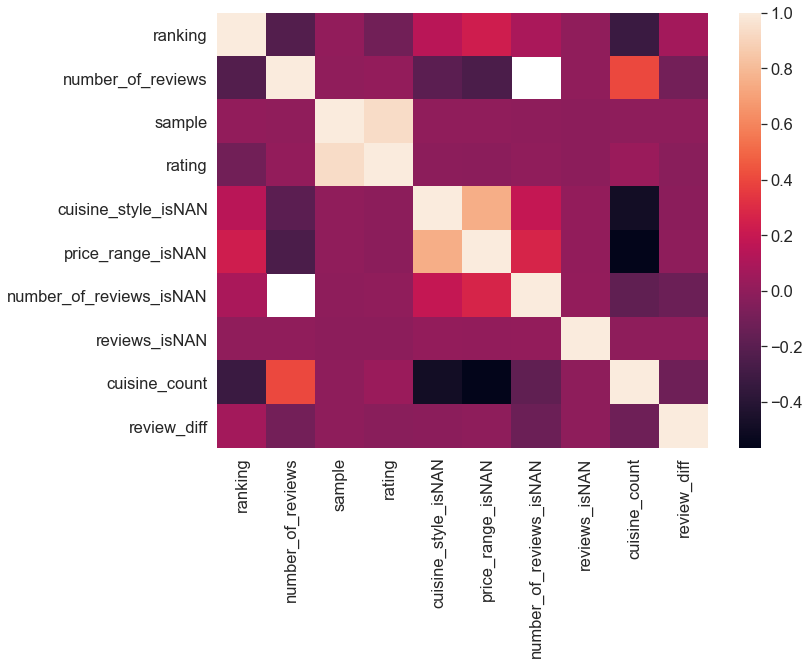

In [43]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')
print(data.select_dtypes('number').corr().loc['number_of_reviews'].sort_values())

sns.heatmap(data.select_dtypes('number').corr());

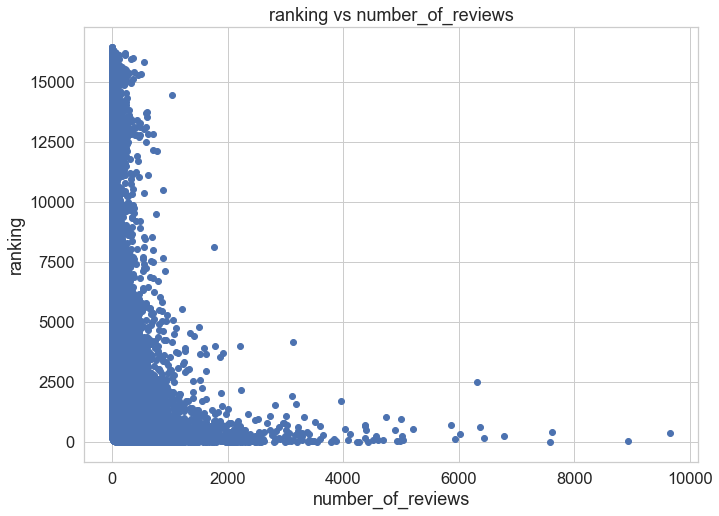

In [44]:
plt.scatter(data.number_of_reviews, data.ranking)
plt.title("ranking vs number_of_reviews")
plt.xlabel("number_of_reviews")
plt.ylabel("ranking")
plt.show()

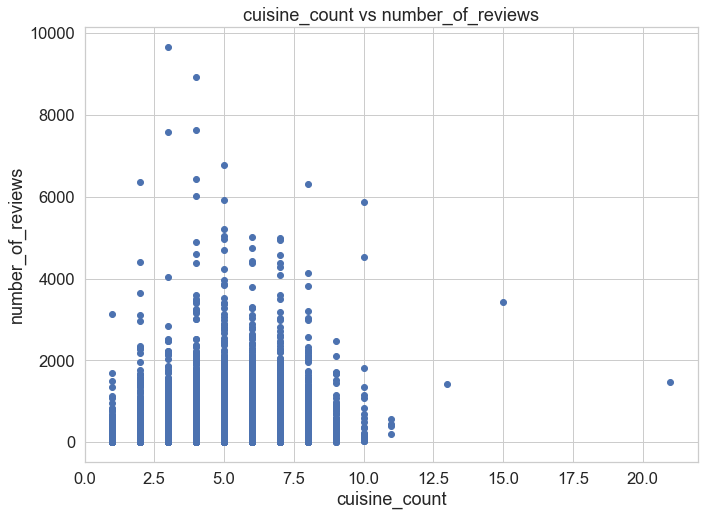

In [45]:
plt.scatter(data.cuisine_count, data.number_of_reviews)
plt.title("cuisine_count vs number_of_reviews")
plt.xlabel("cuisine_count")
plt.ylabel("number_of_reviews")
plt.show()

In [46]:
data.number_of_reviews.describe()

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: number_of_reviews, dtype: float64

Разница между средним значением и медианой большая: есть большие выбросы, влияющие сильно на среднее значение. 

In [47]:
print(data.number_of_reviews.mean())
print(data.number_of_reviews.median())
print(data.number_of_reviews.std())

124.47119658119658
33.0
294.1143451116421


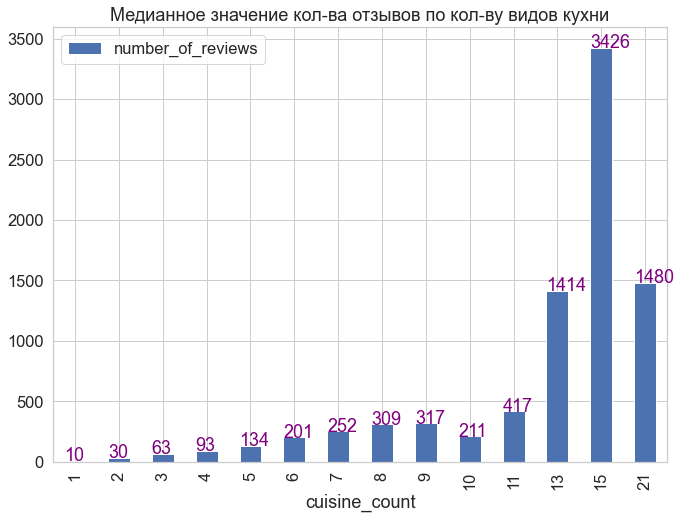

In [48]:
# Вычислить медиану для каждой группы рестроранов, сгруппированных по кол-ву предлагаемых видов кухни. 
reviews_count_data = pd.DataFrame(data.groupby('cuisine_count').median().number_of_reviews)
plot = reviews_count_data.plot.bar(title='Медианное значение кол-ва отзывов по кол-ву видов кухни')
for p in plot.patches:
    plot.annotate(str(int(p.get_height())), (p.get_x() , p.get_height()), color='purple')

In [49]:
# Заполнить неизвестные значения медианой соответсвенно группе, которой принадлежит ресторан. 
data.number_of_reviews = data.apply(lambda row: (reviews_count_data.loc[row.cuisine_count])[0] if np.isnan(row.number_of_reviews) else row.number_of_reviews,axis=1)

In [50]:
data.price_range = data.price_range.map({'$': 1, '$$ - $$$': 2, '$$$$': 3})

## Feature Engineering, обработка новых признаков и РАД

Создаю новые признаки, путем добавления информации из других датасетов, импортированных ранее. 

### Новые признаки **capital**, **is_capital**, **population**, **coastline**, **gdp**, **phones**, **agriculture**, **service**

In [51]:
new_cols = ['country','capital','population','coastline','gdp','phones','agriculture','service']
for col in new_cols:
    data[col] = pd.Series(np.array([None]*data.shape[0]))

# Заполнить значения новых признаков в главном датасете с помощью датасета о городах. 
for city_name in data.city.unique():
    if city_name in cities.index:
        try:
            data.loc[(data.city == city_name), 'country'] = cities.loc[city_name].country
            data.loc[(data.city == city_name), 'population'] = int(cities.loc[city_name].population)
        except:
            data.loc[(data.city  == city_name), 'country'] = cities.loc[city_name].country.values[0]
            data.loc[(data.city == city_name), 'population'] = int(cities.loc[city_name].population.values[0])

for country_name in data.country.unique():
    if country_name in capitals.index:
            data.loc[data.country == country_name,'capital'] = capitals.loc[country_name].capital
    if country_name in countries.index:
        for col in ['coastline','gdp','phones','agriculture','service']:
                data.loc[data.country == country_name, col] = countries.loc[country_name][col]
data[new_cols]

,country,capital,population,coastline,gdp,phones,agriculture,service
0,France,Paris,11020000,"0,63",27600,"586,4","0,022","0,764"
1,Finland,Helsinki,642045,"0,37",27400,"405,3","0,028","0,676"
2,United Kingdom,London,488050,"5,08",27700,"543,5","0,005","0,758"
3,United Kingdom,London,10979000,"5,08",27700,"543,5","0,005","0,758"
4,Slovakia,Bratislava,429564,"0,00",13300,"220,1","0,035","0,672"
...,...,...,...,...,...,...,...,...
49995,Italy,Rome,1351562,"2,52",26700,"430,9","0,021","0,688"
49996,France,Paris,11020000,"0,63",27600,"586,4","0,022","0,764"
49997,Sweden,Stockholm,972647,"0,72",26800,"715,0","0,011","0,707"
49998,Poland,Warsaw,1790658,"0,16",11100,"306,3","0,05","0,64"


In [52]:
to_change = ['coastline','phones','agriculture','service','gdp']
for col in to_change: 
    data[col] = pd.to_numeric(data[col].astype(str).str.replace(',','.'), errors='coerce')

In [53]:
data[new_cols]

,country,capital,population,coastline,gdp,phones,agriculture,service
0,France,Paris,11020000,0.63,27600.0,586.4,0.022,0.764
1,Finland,Helsinki,642045,0.37,27400.0,405.3,0.028,0.676
2,United Kingdom,London,488050,5.08,27700.0,543.5,0.005,0.758
3,United Kingdom,London,10979000,5.08,27700.0,543.5,0.005,0.758
4,Slovakia,Bratislava,429564,0.00,13300.0,220.1,0.035,0.672
...,...,...,...,...,...,...,...,...
49995,Italy,Rome,1351562,2.52,26700.0,430.9,0.021,0.688
49996,France,Paris,11020000,0.63,27600.0,586.4,0.022,0.764
49997,Sweden,Stockholm,972647,0.72,26800.0,715.0,0.011,0.707
49998,Poland,Warsaw,1790658,0.16,11100.0,306.3,0.050,0.640


In [54]:
# Заполнить вручную отстутствующие значения для популяции и стран.
data.loc[(data.city == 'Oporto'), 'population'] = 214349
data.loc[(data.city == 'Zurich'), 'population'] = 402762
data.loc[(data.city == 'Krakow'), 'population'] = 766683

data.loc[(data.city == 'Oporto'), 'country'] = 'Portugal'
data.loc[(data.city == 'Zurich'), 'country'] = 'Switzerland'
data.loc[(data.city == 'Krakow'), 'country'] = 'Poland'

In [55]:
data[data.capital.isnull()]['country'].unique()

array(['Czechia', 'Portugal', 'Poland', 'Switzerland'], dtype=object)

In [56]:
missing_info = {'Czechia': ['Prague', 23495, 0], 'Portugal': ['Lisbon', 23252, 0.98],'Poland': ['Warsaw', 15693, 0],'Switzerland': ['Bern', 81994,0]}

In [57]:
missing_info['Portugal']

['Lisbon', 23252, 0.98]

In [58]:
# Найти для каких стран нет информации по столицам,ввп и соотношению береговой линии и заполнить вручную.
missing = data[data.capital.isnull()]['country'].unique()
missing_info = {'Czechia': ['Prague', 23495, 0], 'Portugal': ['Lisbon', 23252, 0.98],'Poland': ['Warsaw', 15693, 0],'Switzerland': ['Bern', 81994,0]}

for country in missing:
    for i,col in zip([0,1,2], ['capital', 'gdp', 'coastline']):
        data.loc[(data.country == country), col] = missing_info[country][i]

In [59]:
# Создать признак is_capital
new_cols.append('is_capital')
data['is_capital'] = pd.Series(np.array([0]*data.shape[0]))
for capital_name in data.capital.unique():
    data.loc[(data.city == capital_name), 'is_capital'] = 1

In [60]:
data[['country','city','capital','is_capital']].sample(10)

,country,city,capital,is_capital
45301,Switzerland,Zurich,Bern,0
44138,Spain,Barcelona,Madrid,0
28624,United Kingdom,London,London,1
12045,Denmark,Copenhagen,Copenhagen,1
2626,France,Paris,Paris,1
46120,France,Paris,Paris,1
26713,France,Paris,Paris,1
20422,United Kingdom,London,London,1
46273,Czechia,Prague,Prague,1
46860,United Kingdom,London,London,1


Сервис и агрокультура не сильно разнятся по странам или ВВП, поэтому заполняю пропущенные значения средним значением. 

<ipython-input-61-e8e1b22a6bb3>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data.groupby('country')['service','agriculture'].mean().plot.bar(ax = axes[0],rot = 90, title = 'Развитость по сервису vs агрокультуре по странам');
<ipython-input-61-e8e1b22a6bb3>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data.groupby('gdp')['service','agriculture'].mean().plot.bar(ax = axes[1],rot = 90, title = 'Развитость по сервису vs агрокультуре по ВВП');


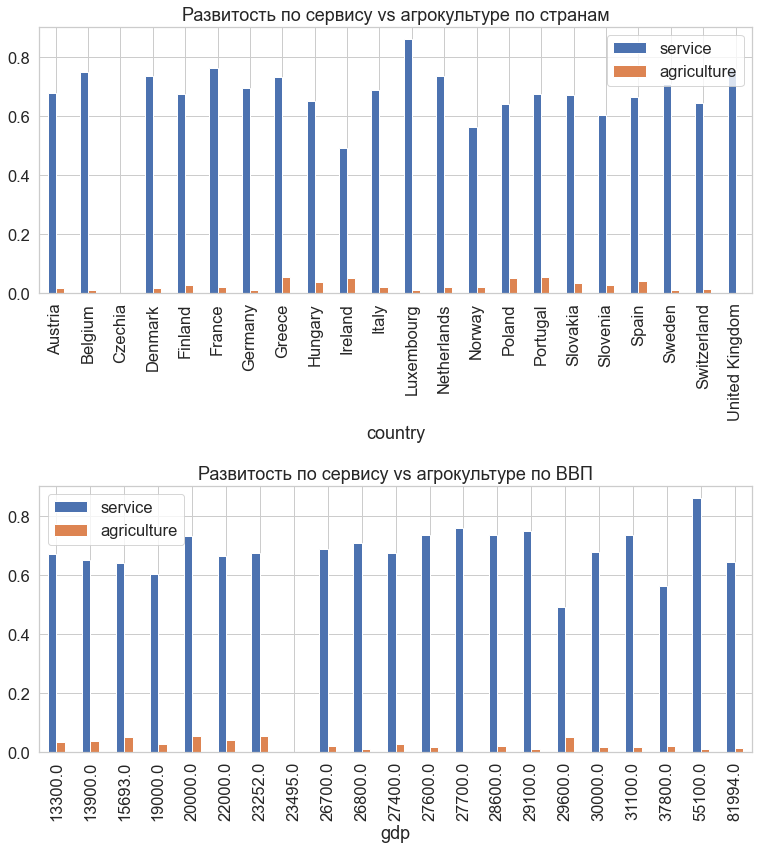

In [61]:
figure, axes = plt.subplots(2, 1, figsize=(15,15))
figure.tight_layout(pad=9.0)

data.groupby('country')['service','agriculture'].mean().plot.bar(ax = axes[0],rot = 90, title = 'Развитость по сервису vs агрокультуре по странам');
data.groupby('gdp')['service','agriculture'].mean().plot.bar(ax = axes[1],rot = 90, title = 'Развитость по сервису vs агрокультуре по ВВП');

Сервис и агрокультура не сильно разнятся по странам или ВВП, поэтому заполняю пропущенные значения средним значением. 

In [62]:
data['service'].fillna(data['service'].mean(), inplace = True)
data['agriculture'].fillna(data['agriculture'].mean(), inplace = True)

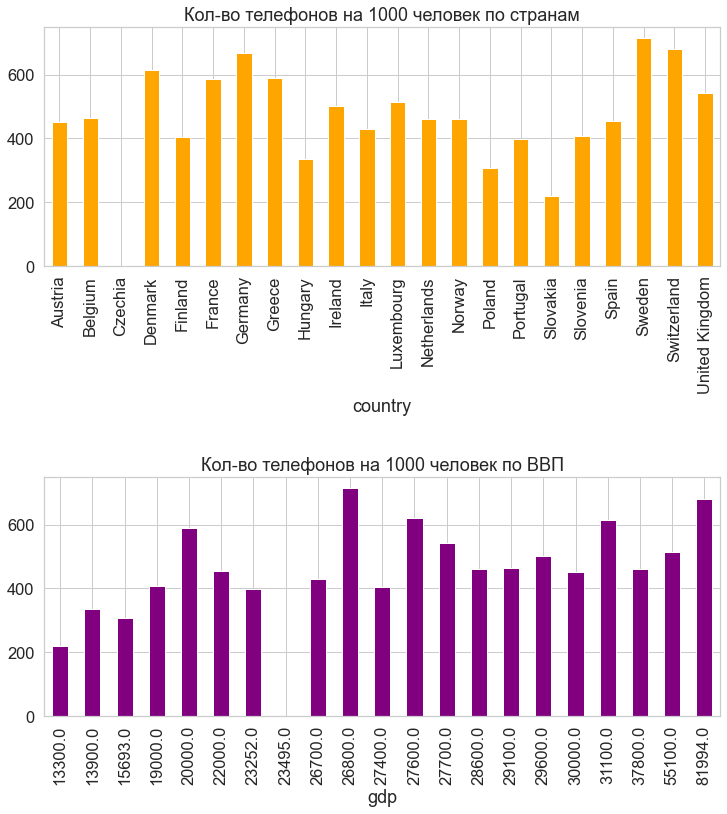

In [63]:
figure, axes = plt.subplots(2, 1, figsize=(15,15))
figure.tight_layout(pad=10)
data.groupby('country')['phones'].mean().plot.bar(ax = axes[0], rot = 90, title = 'Кол-во телефонов на 1000 человек по странам', color='orange')
data.groupby('gdp')['phones'].mean().plot.bar(ax = axes[1],rot = 90, title = 'Кол-во телефонов на 1000 человек по ВВП', color='purple')
plt.show()

Пропущенные значения кол-ва телефонов заменяю медианой,так как значения по странам и ввп разнятся.  

In [64]:
data['phones'].fillna(data['phones'].median(), inplace = True)

Создаю новые признаки с названиями, соответствующими видам кухни

In [65]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

data = data.join(pd.DataFrame(mlb.fit_transform(data.pop('cuisine_style')), index=data.index, columns=mlb.classes_))

In [66]:
# Создать новый столбец с городами, чтобы применить к нему метод get_dummies
data['new_city'] = data['city']
data = pd.get_dummies(data, columns= ['new_city'])

### Более подробный анализ признаков **ranking**, так как он должен быть связан с целевой переменной

<AxesSubplot:>

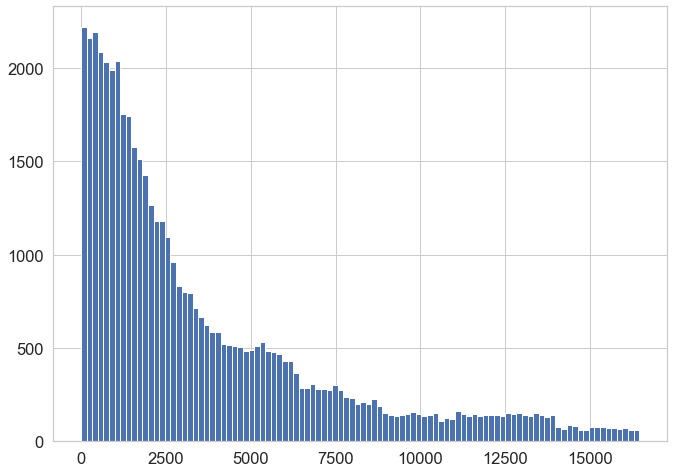

In [67]:
# Посторить распределение ранга ресторонов в общем.
data['ranking'].hist(bins=100)

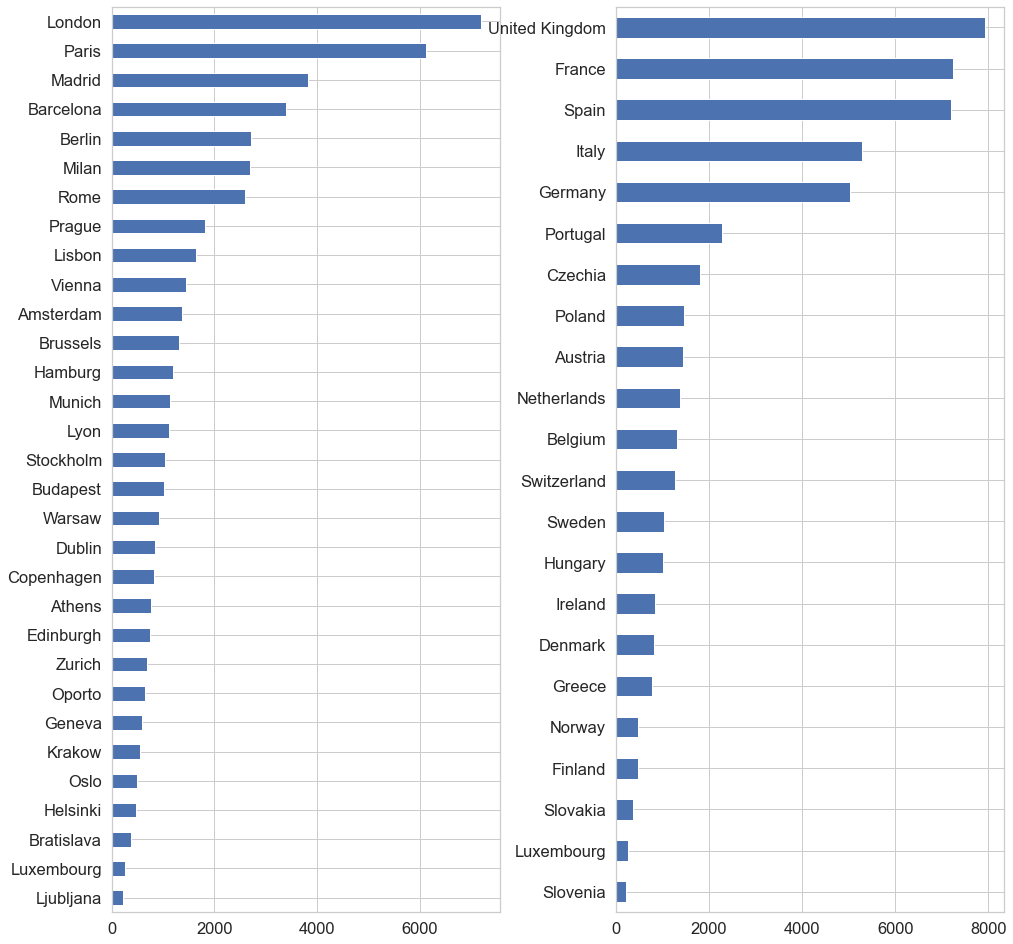

In [68]:
# Рассмотреть количество ресторанов по городам и странам
figure, axes = plt.subplots(1, 2, figsize=(15,15))
figure.tight_layout(pad=4)
data['city'].value_counts(ascending=True).plot(kind='barh',ax=axes[0]);
data['country'].value_counts(ascending=True).plot(kind='barh',ax=axes[1]);

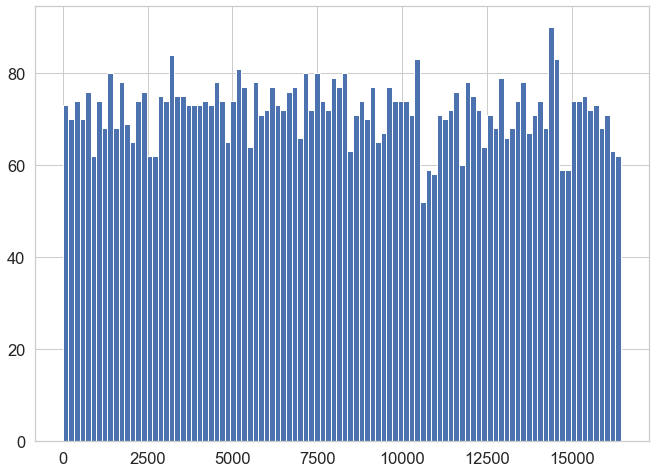

In [69]:
# Рассмотреть распределение ресторанов одного города. 
data['ranking'][data['city'] =='London'].hist(bins=100);

Из гистограммы ниже следует то,что вероятней всего ранг ресторанов не глобальный, а локальный, то есть в каждом городе в отдельности. 

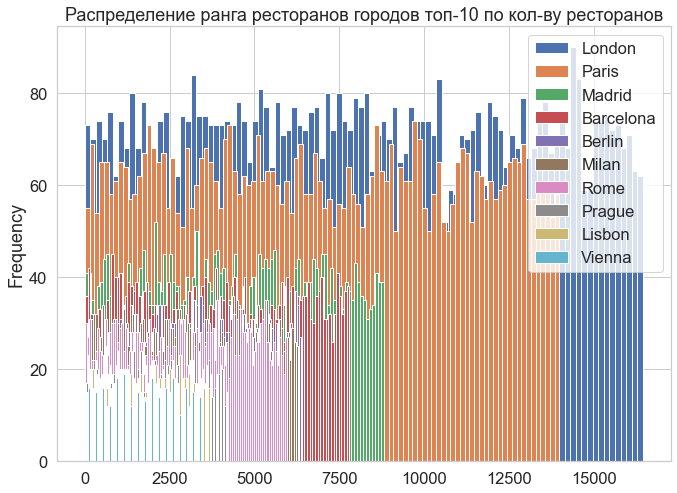

In [70]:
def show_distr(n, by = 'city', of = 'ranking', title = ''):
    top_n = (data[by].value_counts())[0:n].index
    for x in top_n:
        plot = data[of][data[by] == x].plot(kind='hist', legend=True, bins=100, title=title)
    plot.legend(top_n)
    plt.show()
    
def normalise(data, by, feature):
    feature_maxes = data.groupby(by)[feature].max()
    return data[[by, feature]].apply(lambda row: row[feature] / feature_maxes.loc[row[by]], axis=1)

show_distr(10, title = 'Распределение ранга ресторанов городов топ-10 по кол-ву ресторанов')

In [71]:
# Нормализовать переменную с целью подведения под одну шкалу ранг и создать новый признак
data['normalised_rank'] = data['ranking']
data['normalised_rank'] = normalise(data, 'city', 'ranking')
data['normalised_rank']

0        0.926855
1        0.092901
2        0.458664
3        0.101496
4        0.041620
           ...   
49995    0.079681
49996    0.453382
49997    0.670455
49998    0.297586
49999    0.769243
Name: normalised_rank, Length: 50000, dtype: float64

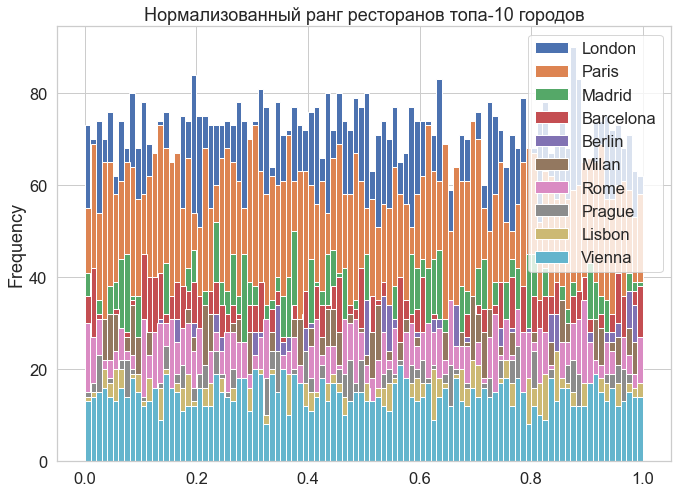

In [72]:
# Показать распределение нового признака нормализованный ранг. 
show_distr(10, 'city', 'normalised_rank', title='Нормализованный ранг ресторанов топа-10 городов')

### Анализ целевой переменной **rating**

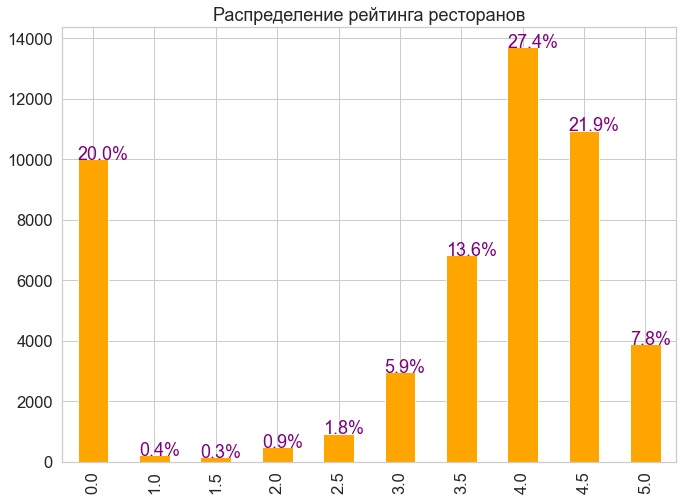

In [73]:
# Постоить гистограмму распределения рейтинга ресторанов.
stats = data['rating'].value_counts(ascending=True).sort_index()
plot = stats.plot(kind='bar', color='orange', title = 'Распределение рейтинга ресторанов')
for p in plot.patches:
    perc = round(int(p.get_height()) / sum(stats.values) * 100,1)
    plot.annotate(str(perc)+'%', (p.get_x() , p.get_height()), color='purple')

# Подготовка

In [74]:
md = data.select_dtypes('number').drop_duplicates()

In [75]:
md

,ranking,price_range,number_of_reviews,sample,rating,cuisine_style_isNAN,price_range_isNAN,number_of_reviews_isNAN,reviews_isNAN,cuisine_count,...,new_city_Oporto,new_city_Oslo,new_city_Paris,new_city_Prague,new_city_Rome,new_city_Stockholm,new_city_Vienna,new_city_Warsaw,new_city_Zurich,normalised_rank
0,12963.0,2,4.0,0,0.0,0,0,0,0,2,...,0,0,1,0,0,0,0,0,0,0.926855
1,106.0,2,97.0,0,0.0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0.092901
2,810.0,2,28.0,0,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.458664
3,1669.0,3,202.0,0,0.0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0.101496
4,37.0,3,162.0,0,0.0,0,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0.041620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,500.0,2,79.0,1,4.5,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0.079681
49996,6341.0,2,542.0,1,3.5,0,0,0,0,5,...,0,0,1,0,0,0,0,0,0,0.453382
49997,1652.0,2,4.0,1,4.5,0,1,0,0,2,...,0,0,0,0,0,1,0,0,0,0.670455
49998,641.0,2,70.0,1,4.0,0,0,0,0,5,...,0,0,0,0,0,0,0,1,0,0.297586


# Обучение модели

In [76]:
# Выделим тестовую часть

train_data = md.query('sample == 1').drop(['sample'], axis=1)
test_data = md.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [77]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [78]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 173), (40000, 173), (40000, 172), (32000, 172), (8000, 172))

# Model 
Сам ML

In [79]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [80]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [81]:
y_pred = np.round(y_pred * 2)/2

In [82]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1710625


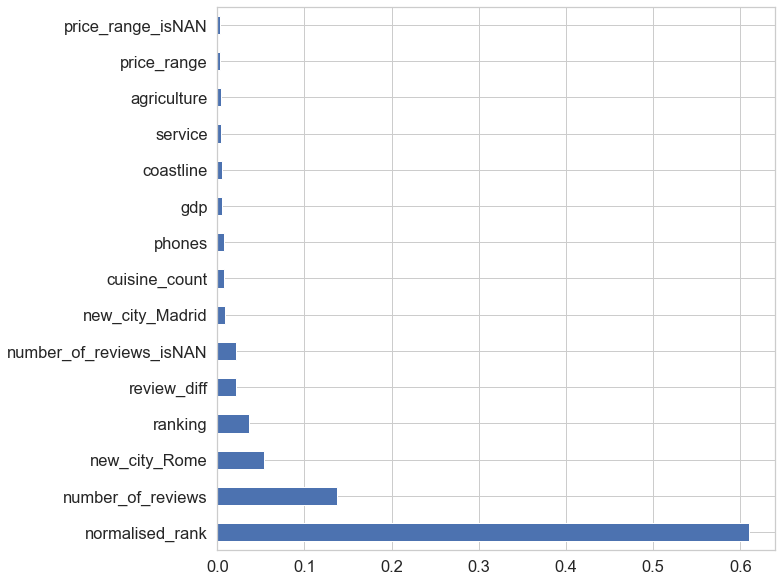

In [83]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

# Submission


In [84]:
test_data.sample(10)

,ranking,price_range,number_of_reviews,rating,cuisine_style_isNAN,price_range_isNAN,number_of_reviews_isNAN,reviews_isNAN,cuisine_count,review_diff,...,new_city_Oporto,new_city_Oslo,new_city_Paris,new_city_Prague,new_city_Rome,new_city_Stockholm,new_city_Vienna,new_city_Warsaw,new_city_Zurich,normalised_rank
6552,33.0,2,844.0,0.0,0,0,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0.005179
6137,323.0,2,81.0,0.0,0,0,0,0,5,67,...,0,0,0,0,0,0,0,0,0,0.086898
9267,7303.0,2,4.0,0.0,1,1,0,0,1,53,...,0,0,0,0,0,0,0,0,0,0.444113
1759,2782.0,1,4.0,0.0,0,0,0,0,2,328,...,0,0,0,0,0,0,0,0,0,0.436598
204,5751.0,1,3.0,0.0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0.966880
7696,2589.0,2,28.0,0.0,0,0,0,0,2,29,...,0,0,0,0,0,0,0,0,0,0.795636
2862,1011.0,2,48.0,0.0,0,0,0,0,2,74,...,0,0,0,0,0,0,0,0,0,0.158663
8792,1195.0,1,162.0,0.0,0,0,0,0,3,96,...,0,0,1,0,0,0,0,0,0,0.085443
2638,4605.0,2,326.0,0.0,0,0,0,0,6,13,...,0,0,0,0,0,0,0,0,0,0.280041
4165,587.0,2,56.0,0.0,0,0,0,0,2,137,...,0,0,0,0,0,0,0,0,0,0.195276


In [85]:
test_data = test_data.drop(['rating'], axis=1)

In [86]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [87]:
predict_submission = np.round(predict_submission * 2)/2

In [89]:
sample_submission['rating'] = predict_submission
sample_submission.to_csv('submission1.csv', index=False)
sample_submission.head(10)

,restaurant_id,rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5
